In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 80

# Domain setup

In [3]:
nx = 101
xar = np.linspace(0, 1, nx)
xg, yg = np.meshgrid(xar, xar)

extent = [0, 1, 0, 1]

def plot_domain(mask, cax=None, cmap=cm.Greys, extent=extent, **kwargs):
    """Plot the domain in black & white"""
    if cax is None:
        cax = plt.gca()
    if not 'alpha' in kwargs:
        kwargs['alpha'] = 0.62
    kwargs['cmap'] = cmap
    im_ = cax.imshow(mask, origin='lower', extent=extent,
                     interpolation='none', zorder=5, **kwargs)
    return im_
    
def plot_measure(a, cax=None, cmap=cm.viridis, extent=extent, **kwargs):
    if cax is None:
        cax = plt.gca()
    kwargs['cmap'] = cmap
    im_ = cax.imshow(a, origin='lower', extent=extent,
                     interpolation='none', **kwargs)
    return im_

(0.0, 1.0, 0.0, 1.0)

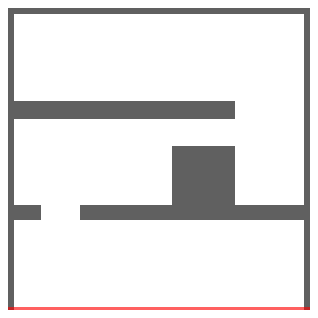

In [4]:
# Obstacle domain
mask = ((0.64 <= yg) & (yg <= 0.7)) & (xg <= 0.75)
mask[:] = mask | ((0.3 <= yg) & (yg <= 0.34)) &\
    ((xg <= 0.10) | (xg >= 0.24))
mask[:] = mask | ((xg <= 0.015) | (xg >= 0.985))
mask[:] = mask | ((yg >= 0.985))
mask[:] = mask | ((np.abs(xg - 0.65) < 0.1) & (np.abs(yg - 0.45) < 0.1))


obstacle_idx = np.argwhere(mask)

domain_img = np.zeros((nx, nx, 4))
domain_img[mask, 3] = 1.

# Exit (target)
exit_mask = (yg < 0.01)

exit_layer = np.zeros((nx, nx, 4))
exit_layer[exit_mask, 0] = 1.
exit_layer[exit_mask, 3] = 1.

fig = plt.figure()
plot_domain(domain_img)
plot_domain(exit_layer)
plt.axis('off')

# Test the sweep

In [7]:
import time

from IPython import display
from sweep import init_grid, update_grid

In [8]:
dx = 1. / (nx-1)

C = np.empty((nx, nx))
speed_field = np.ones_like(C)
speed_field[mask] = 1e5
init_grid(C, exit_mask, init_value=2)

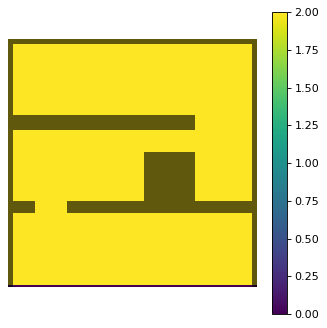

In [9]:
plot_domain(domain_img)
im_ = plot_measure(C)
plt.colorbar(im_)
plt.axis('off');

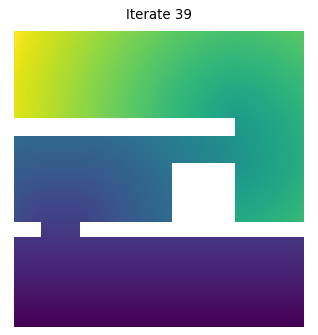

In [10]:
for k in range(40):
    #plot_domain(domain_img)
    C_img = C.copy()
    C_img[mask] = None
    im_ = plot_measure(C_img)
    plt.axis('off');
    plt.title("Iterate %d" % k)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)
    
    update_grid(speed_field, dx, C, False, False)
    update_grid(speed_field, dx, C, True, False)
    update_grid(speed_field, dx, C, True, True)
    update_grid(speed_field, dx, C, False, True)

## Cython sweep

In [11]:
from sweep import fast_sweep

In [35]:
dx = 1. / (nx-1)

C = np.empty((nx, nx))
speed_field = np.ones_like(C)
speed_field[mask] = 1e4
fast_sweep(speed_field, dx, exit_mask, 40, C)

In [36]:
C_filtered = C.copy()
C_filtered[mask] = None

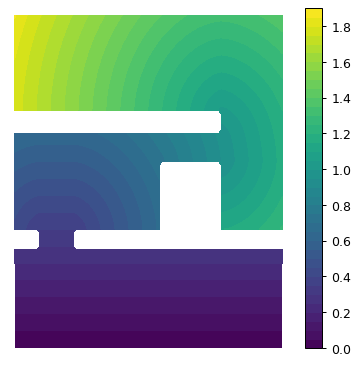

In [39]:
plt.figure(dpi=90)
plt.contourf(C_filtered, levels=40)
plt.colorbar();
plt.axis('off');